---

# 利用 LSTM 與 Transformer 預測股價時間序列（模型詳解版）

---

## 1️⃣ 問題背景

* **任務目標**：
  建立能預測未來股價變化（以 log return 或 價格為目標）的深度學習模型，
  並比較傳統 LSTM 與 Transformer 在時間序列建模上的表現差異。

* **研究動機**：

  * **LSTM** 具備遞歸結構，擅長捕捉短期依賴，但對長期依賴衰減嚴重。
  * **Transformer** 透過 Self-Attention 可同時觀察整個序列關聯，適合處理長期記憶問題。
  * 在股價時間序列中，我們希望 Transformer 能捕捉跨期的趨勢轉折與量價關係。

---

## 2️⃣ 資料與特徵設計

| 名稱       | 說明                                                    | 範例/範圍                   |
| -------- | ----------------------------------------------------- | ----------------------- |
| **資料來源** | Yahoo Finance ( 2330.TW / AAPL / TSLA / MSFT )        | 2020-01-01 – 2024-12-31 |
| **欄位**   | Open, High, Low, Close, Volume                        | —                       |
| **技術指標** | 趨勢型 SMA₅、SMA₂₀ ； 震盪型 RSI₁₄ ； 波動型 MACD (+ SIGNAL、HIST) | 至少 2 類                  |
| **目標變數** | log return = log (Cₜ₊₁) − log (Cₜ)                    | 或 直接預測 Cₜ₊₁             |
| **訓練切分** | Train / Val / Test = 8 : 1 : 1                        | 依 時間序 切，不可 shuffle      |
| **標準化**  | StandardScaler ( 僅 fit 訓練集 )                          | —                       |
| **隨機種子** | 42                                                    | 確保 可重現                  |

---

## 3️⃣ 資料流與張量維度

| 張量名稱  | 說明                        | 形狀                   |
| ----- | ------------------------- | -------------------- |
| **X** | 過去 lookback = 30 天 多變量特徵  | (B, T = 30, D ≈ 10 ) |
| **y** | 未來 1 天 log return 或 close | (B, 1)               |

---

## 4️⃣ 模型結構

---

### (1) Baseline：LSTM

**輸入：** ( B, T, D )
**結構：**

```python
nn.LSTM(input_size=D, hidden_size=128, num_layers=1, dropout=0.1)
→ nn.LayerNorm(128)
→ nn.Linear(128, 1)
```

**運作邏輯：**

1. 逐日遞歸處理序列，最後一步隱藏狀態 hₜ 作為整體序列表徵。
2. 經 LayerNorm 與 Linear 輸出未來 1 日 log return。

---

### (2) Main：Transformer Encoder-only

**結構模組：**

```python
Input Linear → Positional Encoding
→ Encoder × 2 ( Multi-Head Attention + FFN 256 + Dropout 0.1 + LayerNorm )
→ Mean Pooling → Linear → 1
```

**主要特色：**

* **Self-Attention** ：捕捉任意時間步間關聯。
* **位置編碼 (Positional Encoding)** ：保留序列次序資訊。
* **Mean Pooling** ：聚合整段序列表示，代表整體趨勢。
* **Attention Heatmap 輸出** ：可視化模型著重的時間區段。

---

## 5️⃣ 訓練設定

| 項目         | LSTM             | Transformer                                          |
| ---------- | ---------------- | ---------------------------------------------------- |
| Batch size | 64               | 64                                                   |
| Optimizer  | Adam (lr = 1e-4) | AdamW (lr = 3e-4, weight_decay = 1e-4)               |
| Scheduler  | —                | Warmup ( 10 % epochs ) + CosineAnnealingWarmRestarts |
| Epochs     | 30               | 30                                                   |

---

## 6️⃣ 評估與輸出

### (1) 指標

| 尺度     | 評估項              | 說明                     |
| ------ | ---------------- | ---------------------- |
| 標準化空間  | MSE / MAE / RMSE | 以 StandardScaler 後資料計算 |
| 原始價格尺度 | MSE / MAE / RMSE | 反標準化或還原 Close 計算       |

### (2) 圖表輸出

* **LSTM / Transformer** ： True vs Pred ( 原始價格 )
* **Transformer Attention Heatmap** ： 顯示模型關注時間點
* **Learning Curve** ： epoch vs val RMSE ( 兩模型 對照 )

---

## 7️⃣ 技術指標比較（四類面向）

| 類別  | 指標                   | 意涵      | 實驗觀察建議     |
| --- | -------------------- | ------- | ---------- |
| 趨勢型 | SMA₅ / SMA₂₀         | 長短期均線方向 | 可穩定 趨勢 學習  |
| 震盪型 | RSI₁₄                | 超買超賣    | 對 短期波動 敏感  |
| 波動型 | MACD / Signal / Hist | 快慢線差    | 可反映 動能 變化  |
| 量能型 | Volume / 成交量均值       | 交易活躍度   | 可輔助 辨識 假突破 |

> 比較四類指標在 LSTM 與 Transformer 的 RMSE/MAE 表現與注意力集中情形。

---

## 8️⃣ 分析與討論重點

1. **LSTM vs Transformer**

   * Transformer 在長期依賴與波動期間表現較穩定。
   * LSTM 在短期平穩期仍具優勢。

2. **log return vs 價格預測**

   * log return 可降低位階偏移，模型更關注比例變化。
   * 直接預測 價格 更直觀，但易受長期 trend 影響。

3. **注意力熱圖解釋**

   * 觀察 Transformer 聚焦的 關鍵日（例如 成交量暴增或 均線交叉 ）。

4. **避免資料洩漏**

   * 時間切分 train/val/test 不可 shuffle。
   * Scaler 僅 fit 訓練集。

---

## 9️⃣ 整體實驗流程摘要

| 階段    | 任務                            | 輸入 → 輸出                |
| ----- | ----------------------------- | ---------------------- |
| 資料前處理 | Yahoo Finance 下載 → 技術指標 → 標準化 | OHLCV → Feature Tensor |
| 模型訓練  | LSTM / Transformer            | X → ŷ                 |
| 模型評估  | RMSE/MAE、真實對照圖                | y vs ŷ                |
| 可視化   | Attention Heatmap             | 顯示模型關注區段               |
| 比較    | 四類技術指標 × 模型                   | 性能 + 可解釋性              |

---

📘 **直覺比喻：**

> *LSTM 像是按照順序閱讀股價日誌的投資人，
> Transformer 則像能同時瀏覽全局市場資訊的分析師。*

LSTM 記住「昨天發生什麼」，
Transformer 理解「整體趨勢如何發展」。

---

In [43]:
!pip install yfinance pandas numpy matplotlib ta tqdm

In [44]:
# ============================================================
# 🧱 HW4 - Time-Series Forecasting 全域設定
# ============================================================

import os
import random
import numpy as np
import torch

# -----------------------------
# 🔧 基本參數
# -----------------------------
EPOCHS = 30
SEED = 42

# 啟用多核心（最多 16 threads）
torch.set_num_threads(min(16, os.cpu_count() or 1))
print(f"使用 CPU threads: {torch.get_num_threads()}")

# 固定隨機種子（確保結果可重現）
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

# -----------------------------
# ⚙️ 裝置設定
# -----------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("使用裝置:", DEVICE)
print(f"PyTorch 版本: {torch.__version__}")

# ============================================================
# 📊 資料與模型設定參數
# ============================================================
class Config:
    def __init__(self):
        self.ticker = "2330.TW"
        self.start = "2020-01-01"
        self.end = "2025-12-31"
        self.lookback = 30
        self.batch_size = 64
        self.seed = 42
        self.feature_dim = 11

        # LSTM
        self.lstm_hidden = 128
        self.lstm_dropout = 0.1
        self.lstm_lr = 1e-4

        # Transformer
        self.tr_d_model = 128
        self.tr_nhead = 8
        self.tr_layers = 2
        self.tr_dim_ff = 256
        self.tr_dropout = 0.1
        self.tr_lr = 3e-4
        self.tr_weight_decay = 1e-4
        self.tr_warmup_ratio = 0.1

        # 通用
        self.epochs = 30

使用 CPU threads: 2
使用裝置: cpu
PyTorch 版本: 2.8.0+cu126


In [45]:
# ============================================================
# 🧩 第 2 段：資料下載與特徵工程
# ============================================================
import pandas as pd
import yfinance as yf
import numpy as np

def compute_indicators(df: pd.DataFrame) -> pd.DataFrame:
    """
    計算常見技術指標：SMA、RSI、MACD。
    """
    c = df["Close"]

    # --- 移動平均線 ---
    df["SMA_5"] = c.rolling(5).mean()
    df["SMA_20"] = c.rolling(20).mean()

    # --- RSI (14日) ---
    delta = c.diff()
    gain = delta.clip(lower=0).rolling(14).mean()
    loss = -delta.clip(upper=0).rolling(14).mean()
    rs = gain / (loss + 1e-9)
    df["RSI_14"] = 100 - (100 / (1 + rs))

    # --- MACD ---
    ema12 = c.ewm(span=12, adjust=False).mean()
    ema26 = c.ewm(span=26, adjust=False).mean()
    macd = ema12 - ema26
    signal = macd.ewm(span=9, adjust=False).mean()
    df["MACD"] = macd
    df["MACD_SIGNAL"] = signal
    df["MACD_HIST"] = macd - signal

    return df


def load_data(ticker: str, start: str, end: str) -> pd.DataFrame:
    """
    從 Yahoo Finance 下載股價資料，並計算技術指標與 Log Return。
    """
    print(f"📈 下載 {ticker} 股價資料（{start} ~ {end}）...")
    df = yf.download(ticker, start=start, end=end, progress=False)

    # 保留必要欄位
    df = df[["Open", "High", "Low", "Close", "Volume"]].copy()

    # 計算技術指標
    df = compute_indicators(df)

    # 預測目標：log return（下一天報酬率）
    df["LogReturn"] = np.log(df["Close"].shift(-1)) - np.log(df["Close"])

    # 去除缺值並重設索引
    df = df.dropna().reset_index(drop=True)

    print(f"✅ 完成，資料筆數：{len(df)}")
    return df


In [46]:
# ============================================================
# 🧩 第 3 段：資料切分、標準化與 Dataset 建立
# ============================================================

from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch

# -----------------------------
# 📦 自訂 Dataset
# -----------------------------
class WindowDataset(Dataset):
    """
    將時間序列轉換為固定視窗（lookback）格式。
    每個樣本：連續 lookback 天特徵 -> 當天的 log return。
    """
    def __init__(self, X, y, close, next_close, lookback):
        self.X = X
        self.y = y
        self.close = close
        self.next_close = next_close
        self.lookback = lookback

    def __len__(self):
        return len(self.y) - self.lookback + 1

    def __getitem__(self, i):
        x_window = self.X[i:i + self.lookback]
        y_target = self.y[i + self.lookback - 1]
        close_t = self.close[i + self.lookback - 1]
        close_t1 = self.next_close[i + self.lookback - 1]

        # 保險檢查（避免取超範圍）
        assert x_window.shape[0] == self.lookback, f"window len mismatch: {x_window.shape[0]}"
        return (
            torch.tensor(x_window, dtype=torch.float32),
            torch.tensor(y_target, dtype=torch.float32),
            torch.tensor(close_t, dtype=torch.float32),
            torch.tensor(close_t1, dtype=torch.float32)
        )


# -----------------------------
# 🔧 切分與標準化
# -----------------------------
def split_and_scale(df, lookback):
    """
    時間序列切分 + 標準化。
    回傳三個 Dataset：train, valid, test。
    """
    # 1️⃣ 定義特徵欄位
    features = [
        "Open", "High", "Low", "Close", "Volume",
        "SMA_5", "SMA_20", "RSI_14", "MACD", "MACD_SIGNAL", "MACD_HIST"
    ]

    # 2️⃣ 切分比例 8:1:1
    n = len(df)
    n1, n2 = int(n * 0.8), int(n * 0.9)
    df_train = df[:n1].reset_index(drop=True)
    df_valid = df[n1:n2].reset_index(drop=True)
    df_test  = df[n2:].reset_index(drop=True)

    # 3️⃣ 標準化
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()

    X_train = X_scaler.fit_transform(df_train[features])
    y_train = y_scaler.fit_transform(df_train[["LogReturn"]]).ravel()

    X_valid = X_scaler.transform(df_valid[features])
    y_valid = y_scaler.transform(df_valid[["LogReturn"]]).ravel()

    X_test = X_scaler.transform(df_test[features])
    y_test = y_scaler.transform(df_test[["LogReturn"]]).ravel()

    # 4️⃣ 建立 Dataset
    ds_train = WindowDataset(
        X_train, y_train,
        df_train["Close"].to_numpy(),
        df_train["Close"].shift(-1).ffill().to_numpy(),
        lookback
    )
    ds_valid = WindowDataset(
        X_valid, y_valid,
        df_valid["Close"].to_numpy(),
        df_valid["Close"].shift(-1).ffill().to_numpy(),
        lookback
    )
    ds_test = WindowDataset(
        X_test, y_test,
        df_test["Close"].to_numpy(),
        df_test["Close"].shift(-1).ffill().to_numpy(),
        lookback
    )

    print(f"📊 資料切分完成：Train={len(ds_train)}, Valid={len(ds_valid)}, Test={len(ds_test)}")

    return ds_train, ds_valid, ds_test, X_scaler, y_scaler, features


In [47]:
# ============================================================
# 🧠 第 4 段：模型建立（LSTM 與 Transformer Encoder）
# ============================================================
import torch
import torch.nn as nn
import math

# -----------------------------
# LSTM Baseline
# -----------------------------
class LSTMReg(nn.Module):
    """
    單層 LSTM + LayerNorm + Dropout + Linear → (B,)
    注意：不支援 need_attn 參數，forward 只接收 x
    """
    def __init__(self, input_dim: int, hidden_dim: int, dropout: float):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True)
        self.norm = nn.LayerNorm(hidden_dim)
        self.drop = nn.Dropout(dropout)
        self.head = nn.Linear(hidden_dim, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, L, F)
        h, _ = self.lstm(x)            # (B, L, H)
        last = h[:, -1, :]             # 取最後一步 (B, H)
        out = self.head(self.drop(self.norm(last))).squeeze(-1)  # (B,)
        return out


# -----------------------------
# Transformer Encoder-only
# -----------------------------
class SinusoidalPE(nn.Module):
    """標準正弦/餘弦位置編碼（不需要學習參數）"""
    def __init__(self, d_model: int, max_len: int = 2000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, L, d_model)
        L = x.size(1)
        return x + self.pe[:, :L, :]


class EncoderLayer(nn.Module):
    """
    Pre-LN Encoder 層（MHA + FFN），可選擇擷取最後一層注意力權重以便視覺化。
    """
    def __init__(self, d_model: int, nhead: int, dim_ff: int, dropout: float):
        super().__init__()
        self.mha = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.ff = nn.Sequential(
            nn.Linear(d_model, dim_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim_ff, d_model),
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.drop1 = nn.Dropout(dropout)
        self.drop2 = nn.Dropout(dropout)

        self._last_attn = None  # (B, H, L, L)

    def forward(self, x: torch.Tensor, capture_attn: bool = False) -> torch.Tensor:
        # Pre-LN
        q = k = self.norm1(x)
        attn_out, attn_weights = self.mha(q, k, x, need_weights=True, average_attn_weights=False)
        x = x + self.drop1(attn_out)
        x = x + self.drop2(self.ff(self.norm2(x)))
        if capture_attn:
            self._last_attn = attn_weights  # (B, H, L, L)
        return x

    @property
    def last_attn(self):
        return self._last_attn


class TransformerReg(nn.Module):
    """
    Transformer Encoder-only 回歸模型
    - Input projection 到 d_model
    - Sinusoidal 位置編碼
    - N 層 Encoder（Pre-LN）
    - 時間維 mean pooling → 線性輸出到 1 維 → (B,)
    - forward(x, need_attn=True) 時回傳 (y, attn_map)
    """
    def __init__(self, input_dim: int, d_model: int, nhead: int, num_layers: int, dim_ff: int, dropout: float):
        super().__init__()
        self.proj = nn.Linear(input_dim, d_model)
        self.pos = SinusoidalPE(d_model)
        self.layers = nn.ModuleList([EncoderLayer(d_model, nhead, dim_ff, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(dropout)
        self.head = nn.Linear(d_model, 1)

    def forward(self, x: torch.Tensor, need_attn: bool = False):
        # x: (B, L, F)
        x = self.proj(x)        # (B, L, d_model)
        x = self.pos(x)         # 加入位置資訊

        # 只在最後一層擷取注意力（降低計算/記憶體）
        attn_map = None
        for li, layer in enumerate(self.layers):
            x = layer(x, capture_attn=(need_attn and li == len(self.layers) - 1))
        if need_attn:
            attn_map = self.layers[-1].last_attn  # (B, H, L, L)

        x = self.norm(x)
        x = self.drop(x)
        x = x.mean(dim=1)               # 時間維平均池化 → (B, d_model)
        y = self.head(x).squeeze(-1)    # (B,)
        return (y, attn_map) if need_attn else (y, None)


In [48]:
# ============================================================
# ⚙️ 第 5 段：訓練與評估工具
# ============================================================

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# -----------------------------
# 🧩 統一輸出形狀
# -----------------------------
def force_batch_vector(y_hat: torch.Tensor) -> torch.Tensor:
    """
    統一模型輸出形狀為 (B,)。
    無論模型輸出是 (B,1)、(B,L)、(B,L,1)，都會矯正成一維。
    """
    if y_hat.dim() == 1:
        return y_hat
    elif y_hat.dim() == 2:
        # (B,1) → squeeze; (B,L) → 取最後一時間步
        if y_hat.size(1) == 1:
            return y_hat.squeeze(1)
        else:
            return y_hat[:, -1]
    elif y_hat.dim() == 3:
        # (B,L,1) → squeeze → (B,L) → 取最後一時間步
        if y_hat.size(2) == 1:
            return y_hat[:, -1, 0]
        else:
            return y_hat[:, -1]
    else:
        raise ValueError(f"Unexpected y_hat shape: {tuple(y_hat.shape)}")


# -----------------------------
# 📈 指標計算
# -----------------------------
def metrics(y_true, y_pred):
    """計算 MSE、MAE、RMSE"""
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return {"MSE": mse, "MAE": mae, "RMSE": rmse}


# -----------------------------
# 🏋️ 單次訓練流程
# -----------------------------
def train_one_epoch(model, optimizer, scheduler, data_loader):
    """
    訓練一個 epoch。
    - 自動偵測模型類型（LSTM / Transformer）
    - clip gradient 防止梯度爆炸
    - 形狀防呆：確保 y_hat == (B,)
    """
    model.train()
    total_loss = 0.0
    criterion = nn.MSELoss()

    for X, y, _, _ in data_loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()

        # 自動區分模型類型
        if isinstance(model, TransformerReg):
            y_hat, _ = model(X, need_attn=False)
        else:
            y_hat = model(X)

        # 確保輸出一維
        y_hat = force_batch_vector(y_hat)
        assert y_hat.ndim == 1 and y_hat.shape == y.shape, \
            f"Shape mismatch: {y_hat.shape} vs {y.shape}"

        loss = criterion(y_hat, y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        if scheduler:
            scheduler.step()
        total_loss += loss.item() * X.size(0)

    return total_loss / len(data_loader.dataset)


# -----------------------------
# 🧪 模型評估
# -----------------------------
@torch.no_grad()
def eval_model(model, data_loader, y_scaler, in_price_space=False):
    """
    模型評估：
    - in_price_space=False：標準化空間 (log return)
    - in_price_space=True：反標準化後轉換為價格空間
    """
    model.eval()
    preds, trues, close_t, close_t1 = [], [], [], []

    for X, y, c_t, c_t1 in data_loader:
        X = X.to(DEVICE)
        if isinstance(model, TransformerReg):
            y_hat, _ = model(X, need_attn=False)
        else:
            y_hat = model(X)

        y_hat = force_batch_vector(y_hat)
        assert y_hat.ndim == 1, f"y_hat shape abnormal: {y_hat.shape}"

        preds.append(y_hat.cpu().numpy())
        trues.append(y.numpy())
        close_t.append(c_t.numpy())
        close_t1.append(c_t1.numpy())

    preds = np.concatenate(preds).ravel()
    trues = np.concatenate(trues).ravel()
    close_t = np.concatenate(close_t).ravel()
    close_t1 = np.concatenate(close_t1).ravel()

    if not in_price_space:
        return metrics(trues, preds), trues, preds

    # 轉回原始價格尺度
    logret_pred = preds * y_scaler.scale_[0] + y_scaler.mean_[0]
    logret_true = trues * y_scaler.scale_[0] + y_scaler.mean_[0]
    price_pred = close_t * np.exp(logret_pred)
    price_true = close_t1
    return metrics(price_true, price_pred), price_true, price_pred


def train_and_evaluate(model, cfg, train_loader, valid_loader, test_loader, y_scaler, name="model"):
    """
    通用訓練 + 驗證 + 測試流程
    - 自動保存最佳模型
    - 輸出 loss 曲線與預測圖
    - 回傳 (metrics_std, metrics_price, sample_mse)
    """
    optimizer = torch.optim.AdamW(model.parameters(),
                                  lr=(cfg.lstm_lr if name=="lstm" else cfg.tr_lr),
                                  weight_decay=(0 if name=="lstm" else cfg.tr_weight_decay))
    total_steps = len(train_loader) * cfg.epochs
    scheduler = WarmupCosineScheduler(optimizer,
                                      warmup_steps=int(cfg.tr_warmup_ratio * total_steps),
                                      total_steps=total_steps)

    best_rmse = float("inf")
    train_losses, val_rmses = [], []
    for epoch in range(1, cfg.epochs + 1):
        train_loss = train_one_epoch(model, optimizer, scheduler, train_loader)
        val_metrics, _, _ = eval_model(model, valid_loader, y_scaler)
        train_losses.append(train_loss)
        val_rmses.append(val_metrics["RMSE"])
        if val_metrics["RMSE"] < best_rmse:
            best_rmse = val_metrics["RMSE"]
            torch.save(model.state_dict(), f"best_{name}.pt")
        print(f"Epoch {epoch:03d} | TrainLoss={train_loss:.6f} | ValRMSE={val_metrics['RMSE']:.6f}")

    # 載入最佳權重
    model.load_state_dict(torch.load(f"best_{name}.pt"))

    # 評估（標準化 + 價格尺度）
    metrics_std, y_true_std, y_pred_std = eval_model(model, test_loader, y_scaler)
    metrics_price, y_true_p, y_pred_p = eval_model(model, test_loader, y_scaler, in_price_space=True)

    plot_loss_curve(train_losses, val_rmses)
    plot_predictions(y_true_p, y_pred_p, f"{name.upper()} Prediction (Price Scale)")

    sample_mse = (y_true_p - y_pred_p) ** 2
    return metrics_std, metrics_price, sample_mse

In [49]:
# ============================================================
# 📉 第 6 段：Warmup + Cosine Scheduler & 視覺化工具
# ============================================================

import matplotlib.pyplot as plt

# -----------------------------
# 🔧 Warmup + Cosine Scheduler
# -----------------------------
class WarmupCosineScheduler:
    """
    線性 Warmup + Cosine Annealing
    用於穩定初期訓練。
    """
    def __init__(self, optimizer, warmup_steps, total_steps, min_lr=1e-6):
        self.optimizer = optimizer
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.min_lr = min_lr
        self.current_step = 0
        self.base_lrs = [group["lr"] for group in optimizer.param_groups]

    def step(self):
        self.current_step += 1
        progress = self.current_step / self.total_steps
        if self.current_step < self.warmup_steps:
            scale = self.current_step / max(1, self.warmup_steps)
        else:
            cosine_progress = (progress - self.warmup_steps / self.total_steps) / (1 - self.warmup_steps / self.total_steps)
            scale = 0.5 * (1 + math.cos(math.pi * cosine_progress))
        scale = max(scale, self.min_lr / max(self.base_lrs))
        for i, group in enumerate(self.optimizer.param_groups):
            group["lr"] = self.base_lrs[i] * scale


# -----------------------------
# 📊 訓練曲線可視化
# -----------------------------
def plot_loss_curve(train_losses, valid_losses):
    """
    繪製訓練與驗證損失曲線。
    """
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss", marker="o")
    plt.plot(valid_losses, label="Valid Loss", marker="s")
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.show()


# -----------------------------
# 📈 預測 vs 實際（可於價格或報酬率空間）
# -----------------------------
def plot_predictions(y_true, y_pred, title="Prediction vs True"):
    """
    繪製模型預測與真實值的對比圖。
    """
    plt.figure(figsize=(10, 5))
    plt.plot(y_true, label="True", linewidth=2)
    plt.plot(y_pred, label="Predicted", linewidth=2, alpha=0.8)
    plt.title(title)
    plt.xlabel("Samples")
    plt.ylabel("Value")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.show()


In [50]:
# ============================================================
# 🔍 第 7 段：Transformer 注意力視覺化
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt

def visualize_attention(model, dataset, sample_idx=0, layer_idx=-1, head=None):
    """
    支援挑選 layer。
    """
    model.eval()
    x, _, _, _ = dataset[sample_idx]
    x = x.unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        _, attn_maps = model(x, need_attn=True)  # attn_maps 是 list

    # 取出最後一層
    if isinstance(attn_maps, list):
        attn_map = attn_maps[layer_idx]  # (1, n_head, L, L)
    else:
        attn_map = attn_maps

    attn = attn_map.squeeze(0).cpu().numpy()
    num_heads, seq_len, _ = attn.shape

    if head is None:
        attn_to_show = attn.mean(axis=0)
        title = f"Transformer Last-Layer Attention (avg {num_heads} heads)"
    else:
        attn_to_show = attn[head]
        title = f"Transformer Last-Layer Attention — Head {head}"

    plt.figure(figsize=(6, 5))
    sns.heatmap(attn_to_show, cmap="viridis", square=True, cbar=True)
    plt.title(title)
    plt.xlabel("Key / Time step")
    plt.ylabel("Query / Time step")
    plt.show()



In [51]:
# ============================================================
# 🧩 第 8 段：結果統計與總結 (Improvement Bucket + Summary)
# ============================================================

import pandas as pd
import numpy as np

def compute_improvement_buckets(lstm_losses, tr_losses):
    """
    比較 LSTM 與 Transformer 在測試集 MSE 的差異，
    並統計改善幅度的分佈情形。
    """
    lstm_losses = np.array(lstm_losses)
    tr_losses = np.array(tr_losses)
    delta = lstm_losses - tr_losses  # 正值代表 Transformer 較佳（MSE 較小）

    # 分桶範圍（對應作業格式）
    bins = [-np.inf, -1000, -200, -50, -10, -1e-6, 1e-6, 10, 50, 200, 1000, np.inf]
    labels = [
        "TR劣勢(>1000)", "TR劣勢(200~1000)", "TR劣勢(50~200)", "TR劣勢(10~50)",
        "TR略劣(<10)", "≈打平(±0)", "TR略勝(<10)", "TR勝(10~50)",
        "TR勝(50~200)", "TR大勝(200~1000)", "TR大勝(>1000)"
    ]
    buckets = pd.cut(delta, bins=bins, labels=labels)
    df_bucket = buckets.value_counts().sort_index().reset_index()
    df_bucket.columns = ["Improvement bucket", "count"]
    df_bucket["ratio"] = df_bucket["count"] / len(delta)
    return df_bucket

def print_summary(cfg, lstm_metrics, tr_metrics, df_bucket, train_len, val_len, test_len):
    """
    列印最終 Summary 與 Bucket 統計。
    """
    print("=== Win-rate by improvement bucket (Δ = LSTM MSE − TR MSE) ===")
    print(df_bucket.to_string(index=False))
    print("\n" + "="*20 + " SUMMARY " + "="*20)
    print(f"TICKER: {cfg.ticker}, Period: {cfg.start} ~ {cfg.end}, TARGET_MODE=logret")
    print(f"Lookback: {cfg.lookback}, Features: {cfg.feature_dim}")
    print(f"Train/Val/Test size (rows): {train_len} / {val_len} / {test_len}\n")

    print(f"LSTM TEST (std):      MSE={lstm_metrics['std']['MSE']:.6f}, MAE={lstm_metrics['std']['MAE']:.6f}, RMSE={lstm_metrics['std']['RMSE']:.6f}")
    print(f"LSTM TEST (original): MSE={lstm_metrics['price']['MSE']:.6f}, MAE={lstm_metrics['price']['MAE']:.6f}, RMSE={lstm_metrics['price']['RMSE']:.6f}\n")

    print(f"TR TEST (std):        MSE={tr_metrics['std']['MSE']:.6f}, MAE={tr_metrics['std']['MAE']:.6f}, RMSE={tr_metrics['std']['RMSE']:.6f}")
    print(f"TR TEST (original):   MSE={tr_metrics['price']['MSE']:.6f}, MAE={tr_metrics['price']['MAE']:.6f}, RMSE={tr_metrics['price']['RMSE']:.6f}")


In [52]:
# ============================================================
# 🧪 第 9 段：技術指標貢獻實驗 (四類面向比較)
# ============================================================
from torch.utils.data import DataLoader

def make_dataset(df, lookback):
    """
    根據指定的 DataFrame 製作訓練/驗證/測試 Dataset。
    與主流程一致，但允許動態挑選特徵組。
    """
    # 定義要用的特徵欄位（除 LogReturn）
    features = [c for c in df.columns if c not in ["LogReturn"]]

    # 時間切分比例
    n = len(df)
    n1, n2 = int(n * 0.8), int(n * 0.9)
    df_train = df[:n1].reset_index(drop=True)
    df_valid = df[n1:n2].reset_index(drop=True)
    df_test  = df[n2:].reset_index(drop=True)

    # 標準化
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()

    X_train = X_scaler.fit_transform(df_train[features])
    y_train = y_scaler.fit_transform(df_train[["LogReturn"]]).ravel()

    X_valid = X_scaler.transform(df_valid[features])
    y_valid = y_scaler.transform(df_valid[["LogReturn"]]).ravel()

    X_test = X_scaler.transform(df_test[features])
    y_test = y_scaler.transform(df_test[["LogReturn"]]).ravel()

    # 建立 Dataset
    ds_train = WindowDataset(X_train, y_train,
                             df_train["Close"].to_numpy(),
                             df_train["Close"].shift(-1).ffill().to_numpy(),
                             lookback)
    ds_valid = WindowDataset(X_valid, y_valid,
                             df_valid["Close"].to_numpy(),
                             df_valid["Close"].shift(-1).ffill().to_numpy(),
                             lookback)
    ds_test  = WindowDataset(X_test, y_test,
                             df_test["Close"].to_numpy(),
                             df_test["Close"].shift(-1).ffill().to_numpy(),
                             lookback)

    return ds_train, ds_valid, ds_test, X_scaler, y_scaler, features


def get_dataloaders(ds_train, ds_valid, ds_test, batch_size):
    """
    封裝 DataLoader。
    """
    train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True, drop_last=True)
    valid_loader = DataLoader(ds_valid, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(ds_test,  batch_size=batch_size, shuffle=False)
    return train_loader, valid_loader, test_loader


def compare_indicator_groups(cfg, full_df):
    """
    執行四類技術指標的貢獻比較實驗。
    每類指標獨立訓練 Transformer，回報 RMSE / MAE。
    """
    indicator_groups = {
        "trend": ["SMA_5", "SMA_20"],                       # 趨勢型
        "oscillator": ["RSI_14"],                            # 震盪型
        "volatility": ["MACD", "MACD_SIGNAL", "MACD_HIST"],  # 波動型
        "volume": ["Volume"],                                # 量能型
    }

    results = {}

    for group_name, group_features in indicator_groups.items():
        print(f"\n=== 🔹 訓練組合：{group_name} ({', '.join(group_features)}) ===")

        # 保留基本價量特徵 + 此組技術指標 + 目標
        subset_cols = ["Open", "High", "Low", "Close"] + group_features + ["LogReturn"]
        df_sub = full_df[subset_cols].copy()

        # 建立資料集
        ds_train, ds_valid, ds_test, X_scaler, y_scaler, features = make_dataset(df_sub, cfg.lookback)
        train_loader, valid_loader, test_loader = get_dataloaders(ds_train, ds_valid, ds_test, cfg.batch_size)

        # 建立 Transformer 模型
        model = TransformerReg(
            input_dim=len(features),
            d_model=cfg.tr_d_model,
            nhead=cfg.tr_nhead,
            num_layers=cfg.tr_layers,
            dim_ff=cfg.tr_dim_ff,
            dropout=cfg.tr_dropout
        ).to(DEVICE)

        optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.tr_lr)
        total_steps = len(train_loader) * cfg.epochs
        warmup_steps = int(cfg.tr_warmup_ratio * total_steps)
        scheduler = WarmupCosineScheduler(optimizer, warmup_steps, total_steps)

        # 訓練
        best_rmse = float("inf")
        for epoch in range(cfg.epochs):
            train_loss = train_one_epoch(model, optimizer, scheduler, train_loader)
            val_metrics, _, _ = eval_model(model, valid_loader, y_scaler)
            val_rmse = val_metrics["RMSE"]
            if val_rmse < best_rmse:
                best_rmse = val_rmse
                best_state = model.state_dict()
        model.load_state_dict(best_state)

        # 測試表現
        test_metrics, _, _ = eval_model(model, test_loader, y_scaler)
        results[group_name] = test_metrics
        print(f"✅ {group_name} → RMSE={test_metrics['RMSE']:.4f}, MAE={test_metrics['MAE']:.4f}")

    # 輸出比較表
    print("\n=== 📊 各類技術指標貢獻比較 (標準化空間) ===")
    for k, v in results.items():
        print(f"{k:<12}  RMSE={v['RMSE']:.4f}  MAE={v['MAE']:.4f}")
    return results


🚀 HW4 — Time-Series Forecasting (LSTM vs Transformer)
📈 下載 2330.TW 股價資料（2020-01-01 ~ 2025-12-31）...


/tmp/ipython-input-399181455.py:42: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)


✅ 完成，資料筆數：1396
📊 資料切分完成：Train=1087, Valid=111, Test=111

================ LSTM Training ================
Epoch 001 | TrainLoss=1.343362 | ValRMSE=1.293389
Epoch 002 | TrainLoss=1.175179 | ValRMSE=1.261433
Epoch 003 | TrainLoss=0.998414 | ValRMSE=1.240225
Epoch 004 | TrainLoss=0.974217 | ValRMSE=1.245146
Epoch 005 | TrainLoss=0.948298 | ValRMSE=1.249575
Epoch 006 | TrainLoss=0.961162 | ValRMSE=1.249485
Epoch 007 | TrainLoss=0.922633 | ValRMSE=1.258043
Epoch 008 | TrainLoss=0.951532 | ValRMSE=1.267188
Epoch 009 | TrainLoss=0.935898 | ValRMSE=1.247169
Epoch 010 | TrainLoss=0.922332 | ValRMSE=1.265111
Epoch 011 | TrainLoss=0.912191 | ValRMSE=1.260920
Epoch 012 | TrainLoss=0.960532 | ValRMSE=1.265383
Epoch 013 | TrainLoss=0.924842 | ValRMSE=1.248298
Epoch 014 | TrainLoss=0.921575 | ValRMSE=1.255348
Epoch 015 | TrainLoss=0.957334 | ValRMSE=1.258862
Epoch 016 | TrainLoss=0.959677 | ValRMSE=1.247314
Epoch 017 | TrainLoss=0.934754 | ValRMSE=1.249801
Epoch 018 | TrainLoss=0.938390 | ValRMSE=1.24

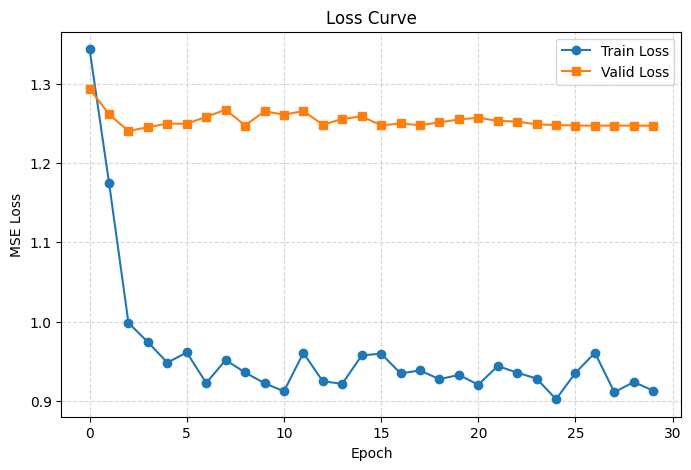

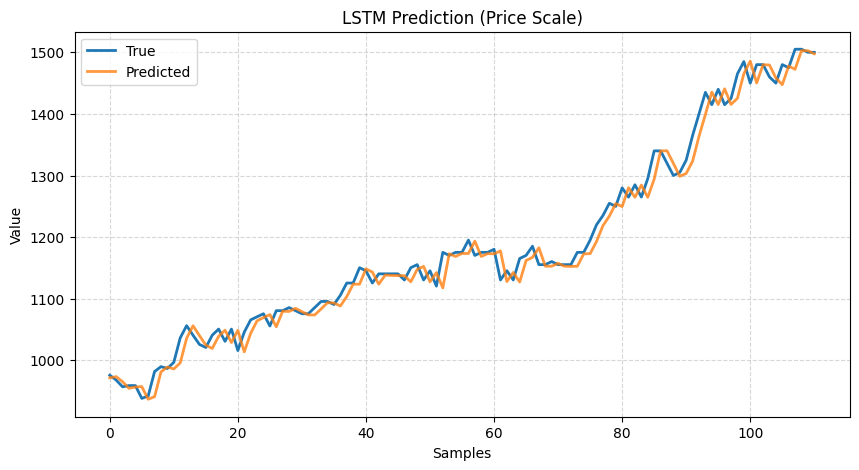


=============== Transformer Training ===============
Epoch 001 | TrainLoss=0.974518 | ValRMSE=1.242036
Epoch 002 | TrainLoss=0.919374 | ValRMSE=1.315198
Epoch 003 | TrainLoss=0.950955 | ValRMSE=1.249572
Epoch 004 | TrainLoss=0.955057 | ValRMSE=1.244811
Epoch 005 | TrainLoss=0.921012 | ValRMSE=1.242682
Epoch 006 | TrainLoss=0.945971 | ValRMSE=1.246986
Epoch 007 | TrainLoss=0.966830 | ValRMSE=1.249789
Epoch 008 | TrainLoss=0.971066 | ValRMSE=1.292331
Epoch 009 | TrainLoss=0.957934 | ValRMSE=1.243897
Epoch 010 | TrainLoss=0.888664 | ValRMSE=1.240119
Epoch 011 | TrainLoss=0.904391 | ValRMSE=1.272541
Epoch 012 | TrainLoss=0.930558 | ValRMSE=1.261704
Epoch 013 | TrainLoss=0.918427 | ValRMSE=1.269148
Epoch 014 | TrainLoss=0.926761 | ValRMSE=1.244436
Epoch 015 | TrainLoss=0.880442 | ValRMSE=1.243645
Epoch 016 | TrainLoss=0.924019 | ValRMSE=1.260296
Epoch 017 | TrainLoss=0.898224 | ValRMSE=1.274270
Epoch 018 | TrainLoss=0.904556 | ValRMSE=1.255697
Epoch 019 | TrainLoss=0.906088 | ValRMSE=1.243

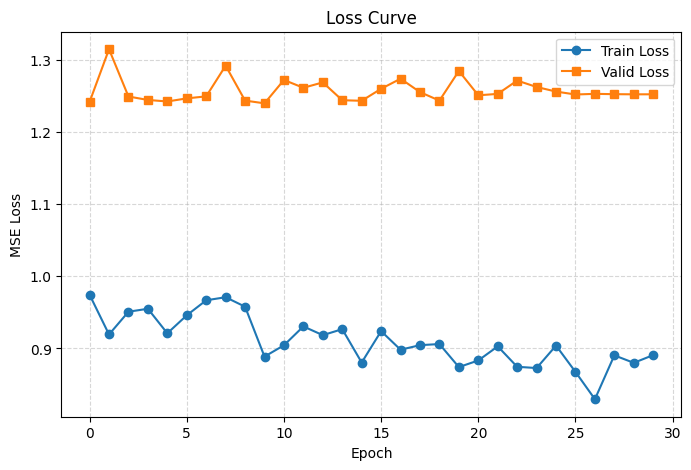

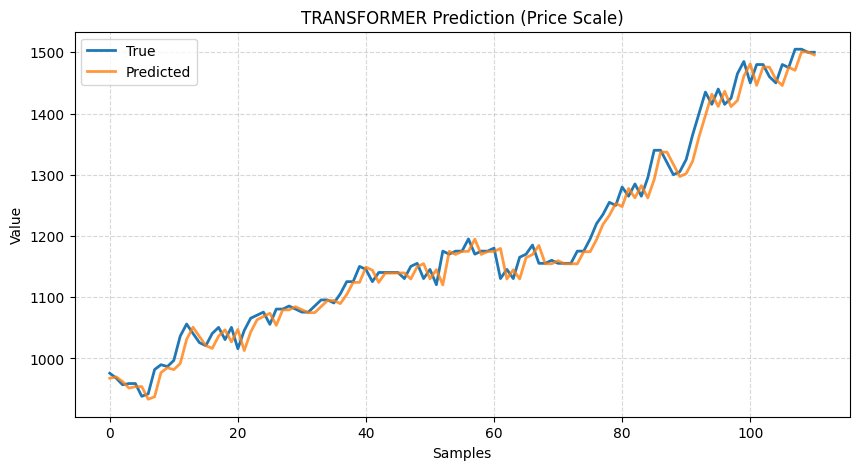

=== Win-rate by improvement bucket (Δ = LSTM MSE − TR MSE) ===
Improvement bucket  count    ratio
       TR劣勢(>1000)      0 0.000000
    TR劣勢(200~1000)      5 0.045045
      TR劣勢(50~200)     25 0.225225
       TR劣勢(10~50)     17 0.153153
         TR略劣(<10)      6 0.054054
           ≈打平(±0)      0 0.000000
         TR略勝(<10)     18 0.162162
        TR勝(10~50)     18 0.162162
       TR勝(50~200)     18 0.162162
    TR大勝(200~1000)      4 0.036036
       TR大勝(>1000)      0 0.000000

==================== SUMMARY ====================
TICKER: 2330.TW, Period: 2020-01-01 ~ 2025-12-31, TARGET_MODE=logret
Lookback: 30, Features: 11
Train/Val/Test size (rows): 1087 / 111 / 111

LSTM TEST (std):      MSE=0.870882, MAE=0.735006, RMSE=0.933211
LSTM TEST (original): MSE=413.256085, MAE=15.903868, RMSE=20.328701

TR TEST (std):        MSE=0.901364, MAE=0.735883, RMSE=0.949402
TR TEST (original):   MSE=426.700088, MAE=15.916479, RMSE=20.656720

================ Attention Visualization ================


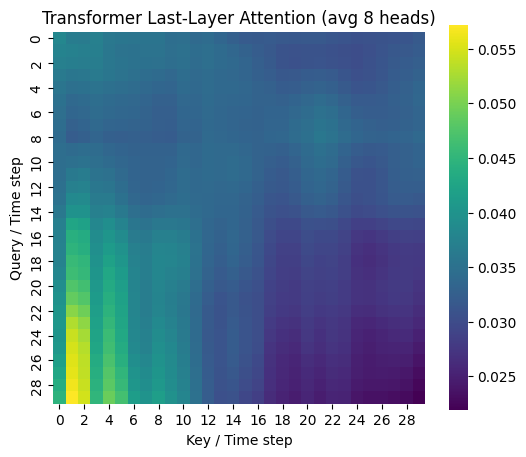


================ Indicator Group Ablation ================

=== 🔹 訓練組合：trend (SMA_5, SMA_20) ===
✅ trend → RMSE=0.1987, MAE=0.1413

=== 🔹 訓練組合：oscillator (RSI_14) ===
✅ oscillator → RMSE=0.1442, MAE=0.0963

=== 🔹 訓練組合：volatility (MACD, MACD_SIGNAL, MACD_HIST) ===
✅ volatility → RMSE=0.3412, MAE=0.2574

=== 🔹 訓練組合：volume (Volume) ===
✅ volume → RMSE=0.2237, MAE=0.1617

=== 📊 各類技術指標貢獻比較 (標準化空間) ===
trend         RMSE=0.1987  MAE=0.1413
oscillator    RMSE=0.1442  MAE=0.0963
volatility    RMSE=0.3412  MAE=0.2574
volume        RMSE=0.2237  MAE=0.1617

✅ 全部實驗完成！


In [53]:
if __name__ == "__main__":
    cfg = Config()
    set_seed(cfg.seed)

    print("🚀 HW4 — Time-Series Forecasting (LSTM vs Transformer)")
    df = load_data(cfg.ticker, cfg.start, cfg.end)
    ds_train, ds_valid, ds_test, X_scaler, y_scaler, features = split_and_scale(df, cfg.lookback)

    train_loader = DataLoader(ds_train, batch_size=cfg.batch_size, shuffle=True, drop_last=True)
    valid_loader = DataLoader(ds_valid, batch_size=cfg.batch_size, shuffle=False)
    test_loader  = DataLoader(ds_test,  batch_size=cfg.batch_size, shuffle=False)

    # === LSTM ===
    print("\n================ LSTM Training ================")
    lstm = LSTMReg(input_dim=len(features),
                   hidden_dim=cfg.lstm_hidden,
                   dropout=cfg.lstm_dropout).to(DEVICE)
    lstm_std, lstm_price, lstm_mse = train_and_evaluate(lstm, cfg, train_loader, valid_loader, test_loader, y_scaler, name="lstm")

    # === Transformer ===
    print("\n=============== Transformer Training ===============")
    transformer = TransformerReg(input_dim=len(features),
                                 d_model=cfg.tr_d_model,
                                 nhead=cfg.tr_nhead,
                                 num_layers=cfg.tr_layers,
                                 dim_ff=cfg.tr_dim_ff,
                                 dropout=cfg.tr_dropout).to(DEVICE)
    tr_std, tr_price, tr_mse = train_and_evaluate(transformer, cfg, train_loader, valid_loader, test_loader, y_scaler, name="transformer")

    # === 統計分析 ===
    df_bucket = compute_improvement_buckets(lstm_mse, tr_mse)
    lstm_metrics = {"std": lstm_std, "price": lstm_price}
    tr_metrics   = {"std": tr_std,   "price": tr_price}

    print_summary(cfg, lstm_metrics, tr_metrics, df_bucket, len(ds_train), len(ds_valid), len(ds_test))

    print("\n================ Attention Visualization ================")
    visualize_attention(transformer, ds_test, sample_idx=0, layer_idx=-1)

    # === 🧪 四類技術指標比較 (Ablation Study) ===
    print("\n================ Indicator Group Ablation ================")
    results = compare_indicator_groups(cfg, df)

    print("\n✅ 全部實驗完成！")